# SORDA - Sprectral Ocean Reflectance Data Assimilation

# 🌊 NECCTON WP4 Data Assimilation Demo

This notebook demonstrates how to run a **portable version of the SORDA** workflow on sample data.  
The pipeline covers:

1. **Preprocessing**  
   - Copy static fields (grid, mask, etc.)  
   - Prepare daily observations and model ensemble members  
   - Harmonize missing values (`_FillValue = -999`)

2. **Assimilation**  
   - Run the OAK Fortran executable for each day  
   - Store daily analysis and increments  

3. **Loop over a period**  
   - Automate multiple days using `month_loop.py`  
   - Incrementally build concatenated files (forecast, analysis, increments, obs)

4. **Post-processing & Plotting**  
   - Compute MAE (time series, depth profiles, Hovmöller)  
   - Compute CRPS (depth-average or selected levels)  
   - Visualize increments (maps, sections)

---

**Outputs written:**
- `forecast_combined.nc`, `analysis_combined.nc`, `increments_combined.nc`, `opti_ref_combined.nc`, `ptrc_ref_combined.nc`
- `runtime_log.csv`

## Requirements

This notebook uses the following Python modules (installed via `pip`):

```bash
pip install numpy xarray netCDF4 matplotlib properscoring


In [13]:
# Minimal deps for the notebook (xarray, netcdf4, properscoring for CRPS, matplotlib)
# %pip install -q numpy xarray netCDF4 properscoring matplotlib

# Loading required package from SORDA python kit

In [2]:
# Point Python to your repo's src/python directory
import sys, pathlib
repo_root = pathlib.Path().resolve()          # or pathlib.Path("/path/to/SORDA")
print(repo_root)
sys.path.append(str(repo_root / "src" / "python"))
SUMMARY_DIR = repo_root / "demo_summaries"
RAWDAT_DIR = repo_root / "SORDA_output"

# (optional) autoreload so edits take effect without restarting the kernel
%load_ext autoreload
%autoreload 2

from month_loop import month_loop
from job import run_assimilation
from prep import main as prep_main
from plotting import (
    plot_mae_hovmoller, plot_mae_global, plot_mae_depth_profile,
    plot_crps_timeseries, plot_crps_levels,
    plot_increments_map, plot_increments_section,
)

/scratch/users/p/v/pverezem/SORDA


## Choose start and end dates for assimilation period (inside 20-29 February 2016)
Usage: month_loop("20160208", "20160214")

In [3]:
start_date = "20160214"
end_date = "20160221"

# Run assimilation

In [15]:
month_loop("20160220", "20160229")


=== 20160220 ===
[prep] date=20160220  workdir=/scratch/users/p/v/pverezem/SORDA/current_day
[prep] copying static fields...
[prep] preparing observations (2D)...
[prep] preparing model ensemble (3D)...
[prep] preparing biogeochemistry ensemble (3D)...
[prep] writing assimilation namelist...
[prep] done ✅
[job] Running: /opt/cecisw/arch/easybuild/2023b/software/OpenMPI/4.1.6-GCC-13.2.0/bin/mpirun -np 4 /scratch/users/p/v/pverezem/SORDA/current_day/assim-gfortran-double-mpi assim.20160220 001 in /scratch/users/p/v/pverezem/SORDA/current_day
[job] Done ✅
[20160220] elapsed: 109.1s
[total so far] 1.8 min

=== 20160221 ===
[prep] date=20160221  workdir=/scratch/users/p/v/pverezem/SORDA/current_day
[prep] copying static fields...
[prep] preparing observations (2D)...
[prep] preparing model ensemble (3D)...
[prep] preparing biogeochemistry ensemble (3D)...
[prep] writing assimilation namelist...
[prep] done ✅
[job] Running: /opt/cecisw/arch/easybuild/2023b/software/OpenMPI/4.1.6-GCC-13.2.0/

## If you'd like, you can generate a set of light-weight summary files to be plotted:

In [ ]:
from summaries import save_mae_summary, save_crps_summary
for var in ['POC', 'CDI','CEM','CFL','GEL','MIC','MES']:
    # MAE
    save_mae_summary(
        RAWDAT_DIR / "forecast_combined.nc",
        RAWDAT_DIR / "analysis_combined.nc",
        RAWDAT_DIR / "ptrc_ref_combined.nc",
        var,
        out_file=SUMMARY_DIR / f"{var}_mae_summary.nc"
    )
    
    # CRPS
    save_crps_summary(
        RAWDAT_DIR / "forecast_combined.nc",
        RAWDAT_DIR / "analysis_combined.nc",
        RAWDAT_DIR / "ptrc_ref_combined.nc",
        var,
        out_file=SUMMARY_DIR / f"{var}_crps_summary.nc"
    )

## 📊 Explore Plotting Functions

Below is a summary of available plotting utilities, their arguments, and what each depiction shows.

## 📝 Notes
- Combined files typically have dims like:  
  - Forecast/Analysis: `(time_counter, ensemble, depth, y, x)`  
  - Obs/Increments: `(time_counter, depth, y, x)` (increments may include `ensemble`)  
- Functions average over `ensemble` when appropriate.  
- Surface-only variables (2D) ignore the `depth` dimension gracefully.  

### Choose one of: 
- **CDI** - diatoms carbon concentration ($mmol/m^3$)

- **CEM** - emiliana / small falgellates carbon concentration ($mmol/m^3$)

- **CFL** - flagellates carbon concentration ($mmol/m^3$)

- **POC** - particulate organic carbon ($mmol/m^3$)

- **MES** - mesozooplankton concentration ($mmol/m^3$)

- **MIC** - microzooplankton concentration ($mmol/m^3$)

- **GEL** - gelatinious zooplankton ($mmol/m^3$)

In [10]:
var = "MES"

### `plot_mae_depth_profile`
**Signature:**  
`plot_mae_depth_profile(forecast_file, analysis_file, obs_file, var, output="mae_profile.png")`  

**Arguments:** same as above.  

**What it shows:**  
Depth profile of MAE averaged over **space (x,y)** and **time**.  
Reveals which **layers** benefit most/least from assimilation.

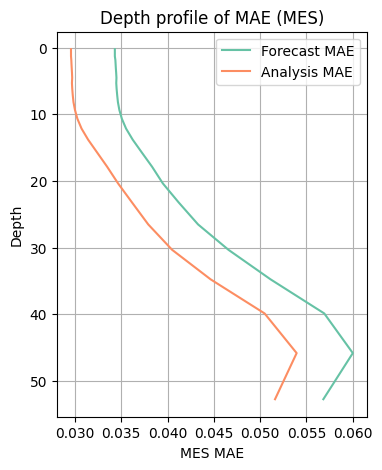

In [11]:
# MAE depth profile
plot_mae_depth_profile(
    RAWDAT_DIR / "forecast_combined.nc", 
    RAWDAT_DIR / "analysis_combined.nc", 
    RAWDAT_DIR / "ptrc_ref_combined.nc", 
    var
)

### `plot_mae_global`
**Signature:**  
`plot_mae_global(forecast_file, analysis_file, obs_file, var, output="mae_global.png")`  

**Arguments:** same as above.  

**What it shows:**  
Time series of **global (x,y,z) mean MAE** for forecast vs. analysis.  
A quick overall skill indicator: does analysis beat forecast over time?

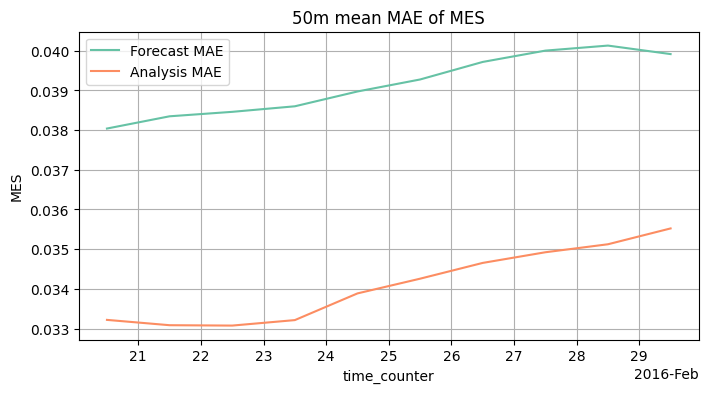

In [12]:
plot_mae_global(
    RAWDAT_DIR / "forecast_combined.nc", 
    RAWDAT_DIR / "analysis_combined.nc", 
    RAWDAT_DIR / "ptrc_ref_combined.nc", 
    var
)

### `plot_mae_hovmoller`
**Signature:**  
`plot_mae_hovmoller(forecast_file, analysis_file, obs_file, var, output="mae_hovmoller.png")`  

**Arguments:**  
- `forecast_file` / `analysis_file` / `obs_file`: paths to combined NetCDFs created by `month_loop.py`  
- `var`: variable name (e.g., `"RRS_443nm"`, `"POC"`)  
- `output`: filename for the saved figure  

**What it shows:**  
Two Hovmöller (time–depth) diagrams of **domain-mean MAE** for forecast and analysis.  
Useful to see how errors evolve with **time** and **depth**, and how assimilation modifies the vertical error structure.

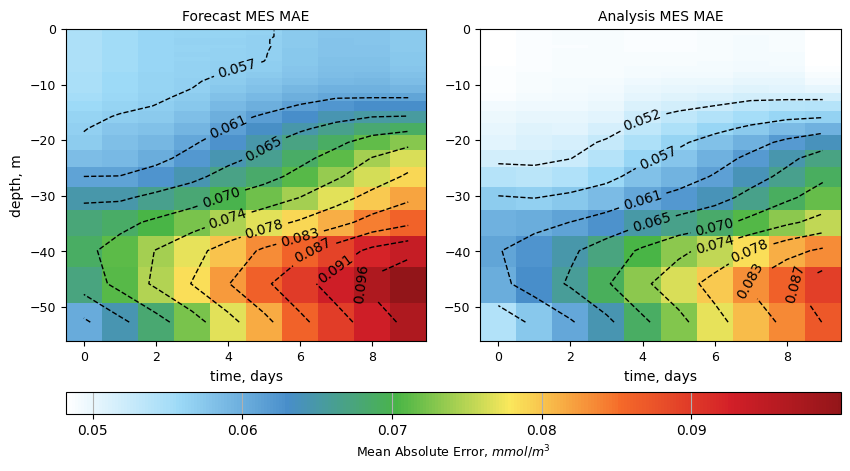

In [13]:
plot_mae_hovmoller(
    RAWDAT_DIR / "forecast_combined.nc",
    RAWDAT_DIR / "analysis_combined.nc",
    RAWDAT_DIR / "ptrc_ref_combined.nc",
    var,
    cmap_txt="./src/python/WhiteBlueGreenYellowRed.txt",
)

### `plot_crps_timeseries`
**Signature:**  
`plot_crps_timeseries(forecast_file, analysis_file, obs_file, var, output="crps_timeseries.png")`  

**Arguments:** same as above.  

**What it shows:**  
Time series of **depth-averaged CRPS** (Continuous Ranked Probability Score) for forecast vs. analysis.  
Lower CRPS = better probabilistic performance; highlights assimilation impact on **ensemble reliability**.

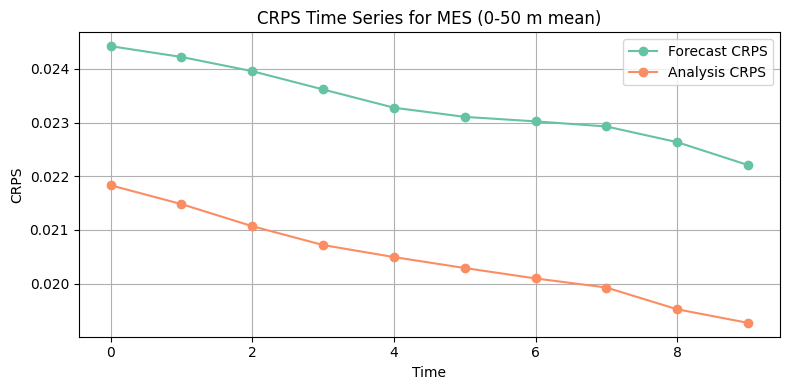

In [14]:
plot_crps_timeseries(
    RAWDAT_DIR / "forecast_combined.nc", 
    RAWDAT_DIR / "analysis_combined.nc", 
    RAWDAT_DIR / "ptrc_ref_combined.nc", 
    var
)

### `plot_crps_levels`
**Signature:**  
`plot_crps_levels(forecast_file, analysis_file, obs_file, var, levels, output="crps_levels.png")`  

**Arguments:**  
- `levels`: list of depths (e.g., `[0, 10, 30]`)  
- Other arguments as above  

**What it shows:**  
CRPS time series **at selected depths**.  
Lets you compare probabilistic skill by **layer**.

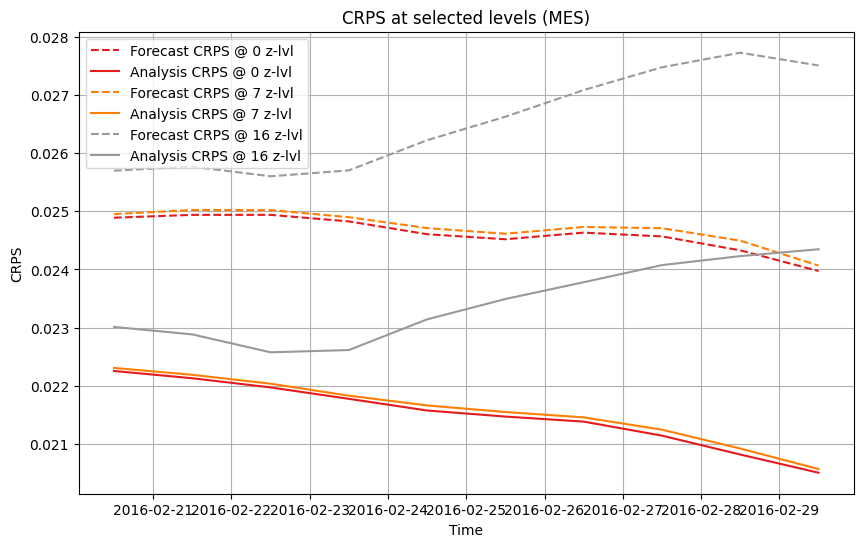

In [15]:
plot_crps_levels(
    RAWDAT_DIR / "forecast_combined.nc", 
    RAWDAT_DIR / "analysis_combined.nc", 
    RAWDAT_DIR / "ptrc_ref_combined.nc", 
    var,
    [0,7,16], 
    output=f"{var}_crps_levels.png")

### `plot_increments_map`
**Signature:**  
`plot_increments_map(increments_file, var, depth=0, date_index=-1, output="increments_map.png")`  

**Arguments:**  
- `increments_file`: path to `increments_combined.nc`  
- `var`: variable name (e.g., `"RRS_443nm"`, `"POC"`)  
- `depth`: depth index (nearest level chosen)  
- `date_index`: time index (`-1` = last)  
- `output`: filename for the saved figure  

**What it shows:**  
**Horizontal map** of increments at one time and depth.  
Highlights **where** assimilation corrects the model and by **how much**.

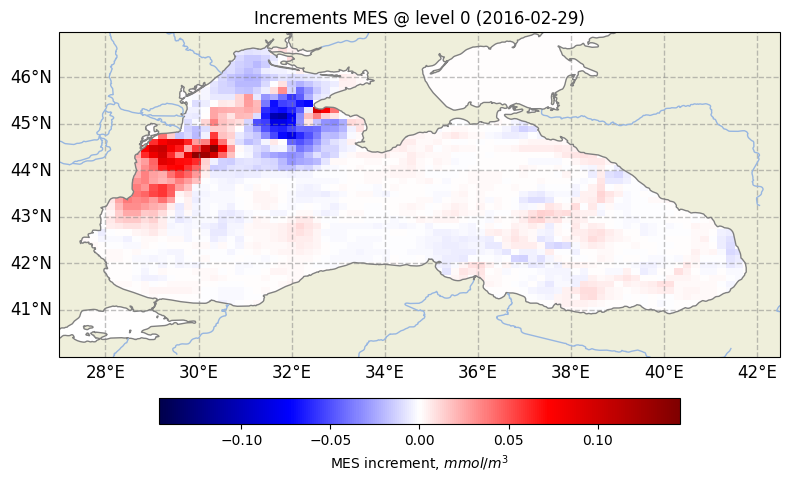

In [16]:
plot_increments_map(
    RAWDAT_DIR / "increments_combined.nc", 
    var, 
    depth=0, 
    date_index=-1)